<a href="https://colab.research.google.com/github/jdasam/ant5015/blob/main/MIR_Assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 4. Automatic Music Transcription
- In this assignment, you have to implement AMT model using CNN and LSTM
- You will use the pre-defined Dataset and small portion of MAESTRO Dataset

- Problems:
  - 1. Implement the AMT model using LSTM (10 pts)
  - 2. Implement the AMT model using CNN + LSTM (10 pts)
  - 3. Implement the Onsets and Frames model using CNN + LSTM (15 pts)
  - 4. Transcription Test (15 pts)
- Submission:
  - Report (in pdf format)
  - Code (in .ipynb format)
  - Audio file for transcription test and output MIDI

- The code of this assignment is based on the following repository:
  - https://github.com/juhannam/gct634-2022/tree/main/hw3 (KAIST GCT634 by Prof. Juhan Nam. Assignment code was largely done by the TA Taegyun Kwon)
  - https://github.com/jongwook/onsets-and-frames (PyTorch implementation of Onsets and Frames by Dr. Jongwook Kim)

## Prepare
- Download dataset
- Install requirements
- Import modules

In [1]:
# !gdown --id 1L99FSzloXGQsmc-OwsVKggvQNF9niN2M
# !unzip -q maestro_small.zip


### Install requirements, import libraries

In [2]:
# !apt install fluidsynth
# !pip install mido pretty_midi mir_eval soundfile pyFluidSynth

In [1]:
import os
import json
import numpy as np
import soundfile
import math
import matplotlib.pyplot as plt
import IPython.display as ipd

from collections import defaultdict
from datetime import datetime
from pathlib import Path

from typing import Dict, List
from numpy import ndarray
from numpy.random.mtrand import RandomState
from pretty_midi.pretty_midi import PrettyMIDI
from tqdm.auto import tqdm


import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
from torch import Tensor
from torchaudio import transforms
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils import clip_grad_norm_
from torch.optim.lr_scheduler import StepLR
import pretty_midi
import fluidsynth

from mido import Message, MidiFile, MidiTrack
from mir_eval.transcription import precision_recall_f1_overlap as evaluate_notes
from mir_eval.util import hz_to_midi, midi_to_hz


SAMPLE_RATE = 16000
MIN_MIDI = 21
MAX_MIDI = 108

HOP_SIZE = 512
N_MELS = 229
N_FFT = 2048
F_MIN = 30
F_MAX = 8000

### Pre-defined code blocks

In [2]:
def allocate_batch(batch:Dict[str,Tensor], device:torch.device) -> Dict[str,Tensor]:
    for key in batch.keys():
        if key != 'path':
            batch[key] = batch[key].to(device)
    return batch

class MAESTRO_small(Dataset):
    def __init__(self,
                 path:str = 'data',
                 groups:List[str] = None,
                 sequence_length:int = SAMPLE_RATE * 5,
                 hop_size:int = HOP_SIZE,
                 seed:int = 42,
                 random_sample:bool = True) -> None:
        self.path:str = path
        self.groups:list = groups if groups is not None else self.available_groups()
        assert all(group in self.available_groups() for group in self.groups)

        self.sample_length:int = ((sequence_length // hop_size) * hop_size) if sequence_length is not None else None
        self.random:RandomState = np.random.RandomState(seed)
        self.random_sample:bool = random_sample
        self.hop_size:int = hop_size

        self.data:List[Dict[str,Tensor]] = []

        print(f'Loading {len(groups)} group(s) of', self.__class__.__name__, 'at', path)
        for group in groups:
            file_list:List[tuple] = self.get_file_path_list_of_group(group)
            for input_files in tqdm(file_list, desc=f'Loading group {group}'):
                self.data.append(self.load(*input_files))

    @classmethod
    def available_groups(cls) -> List[str]:
        return ['train', 'validation', 'test', 'debug']

    def get_file_path_list_of_group(self, group:str) -> List[tuple]:
        metadata:List[dict] = json.load(open(os.path.join(self.path, 'data.json')))
        subset_name:str = 'train' if group == 'debug' else group

        files:List[tuple] = sorted([
                (os.path.join(self.path, row['audio_filename'].replace('.wav', '.flac')),
                 os.path.join(self.path, row['midi_filename']))
                for row in metadata if row['split'] == subset_name
            ])

        if group == 'debug' or group == 'test': # use only 10 files for debug and test
            files = files[:10]

        files = [(audio if os.path.exists(audio) else audio.replace(
                '.flac', '.wav'), midi) for audio, midi in files]

        return files

    def load(self, audio_path:str, midi_path:str) -> Dict[str,Tensor]:
        """Loads an audio track and the corresponding labels."""
        audio, sr = soundfile.read(audio_path, dtype='int16')
        assert sr == SAMPLE_RATE

        frames_per_sec:float = sr / self.hop_size

        audio_tensor:Tensor = torch.ShortTensor(audio)
        audio_length:int = len(audio_tensor)

        midi:PrettyMIDI = pretty_midi.PrettyMIDI(midi_path)
        midi_length_sec:float = midi.get_end_time()
        frame_length:int = min(int(midi_length_sec * frames_per_sec), (audio_length // self.hop_size) + 1)

        audio_tensor = audio_tensor[:frame_length * self.hop_size]

        frame:ndarray = midi.get_piano_roll(fs=frames_per_sec)

        onset = np.zeros_like(frame)
        for inst in midi.instruments:
            for note in inst.notes:
                onset[note.pitch, int(note.start * frames_per_sec)] = 1

        # to shape (time, pitch (88))
        frame_tensor:Tensor = torch.from_numpy(frame[MIN_MIDI:MAX_MIDI + 1].T)
        onset_tensor:Tensor = torch.from_numpy(onset[MIN_MIDI:MAX_MIDI + 1].T)
        data = dict(path=audio_path, audio=audio_tensor, frame=frame_tensor, onset=onset_tensor)
        return data

    def __getitem__(self, index:int) -> Dict[str,Tensor]:
        data:Dict[str,Tensor] = self.data[index]

        audio:Tensor = data['audio']
        frames:Tensor = (data['frame'] >= 1)
        onsets:Tensor = (data['onset'] >= 1)

        frame_len:int = frames.shape[0]

        if self.sample_length is not None:
            n_steps:int = self.sample_length // self.hop_size

            step_begin:int = self.random.randint(frame_len - n_steps) if self.random_sample else 0
            step_end:int = step_begin + n_steps

            sample_begin:int = step_begin * self.hop_size
            sample_end:int = sample_begin + self.sample_length

            audio_seg:Tensor = audio[sample_begin:sample_end]
            frame_seg:Tensor = frames[step_begin:step_end]
            onset_seg:Tensor = onsets[step_begin:step_end]

            result = dict(path=data['path'])
            result['audio'] = audio_seg.float().div_(32768.0)
            result['frame'] = frame_seg.float()
            result['onset'] = onset_seg.float()
        else:
            result = dict(path=data['path'])
            result['audio'] = audio.float().div_(32768.0)
            result['frame'] = frames.float()
            result['onset'] = onsets.float()

        return result

    def __len__(self) -> int:
        return len(self.data)

def evaluate(model, batch, device, save=False, save_path=None):
    metrics = defaultdict(list)
    batch = allocate_batch(batch, device)

    frame_logit, onset_logit = model(batch['audio'])

    criterion = nn.BCEWithLogitsLoss()
    frame_loss = criterion(frame_logit, batch['frame'])
    onset_loss = criterion(onset_logit, batch['onset'])
    metrics['metric/loss/frame_loss'].append(frame_loss.cpu().numpy())
    metrics['metric/loss/onset_loss'].append(onset_loss.cpu().numpy())

    for batch_idx in range(batch['audio'].shape[0]):
        frame_pred = torch.sigmoid(frame_logit[batch_idx])
        onset_pred = torch.sigmoid(onset_logit[batch_idx])

        pr, re, f1 = framewise_eval(frame_pred, batch['frame'][batch_idx])
        metrics['metric/frame/frame_precision'].append(pr)
        metrics['metric/frame/frame_recall'].append(re)
        metrics['metric/frame/frame_f1'].append(f1)

        pr, re, f1 = framewise_eval(onset_pred, batch['onset'][batch_idx])
        metrics['metric/frame/onset_precision'].append(pr)
        metrics['metric/frame/onset_recall'].append(re)
        metrics['metric/frame/onset_f1'].append(f1)

        p_est, i_est = extract_notes(onset_pred, frame_pred)
        p_ref, i_ref = extract_notes(
            batch['onset'][batch_idx], batch['frame'][batch_idx])

        scaling = HOP_SIZE / SAMPLE_RATE

        i_ref = (i_ref * scaling).reshape(-1, 2)
        p_ref = np.array([midi_to_hz(MIN_MIDI + pitch) for pitch in p_ref])
        i_est = (i_est * scaling).reshape(-1, 2)
        p_est = np.array([midi_to_hz(MIN_MIDI + pitch) for pitch in p_est])

        p, r, f, o = evaluate_notes(
            i_ref, p_ref, i_est, p_est, offset_ratio=None)
        metrics['metric/note/precision'].append(p)
        metrics['metric/note/recall'].append(r)
        metrics['metric/note/f1'].append(f)
        metrics['metric/note/overlap'].append(o)

        p, r, f, o = evaluate_notes(i_ref, p_ref, i_est, p_est)
        metrics['metric/note-with-offsets/precision'].append(p)
        metrics['metric/note-with-offsets/recall'].append(r)
        metrics['metric/note-with-offsets/f1'].append(f)
        metrics['metric/note-with-offsets/overlap'].append(o)

        if save:
            stem = Path(batch["path"][batch_idx]).stem
            if len(p_est) == 0:
                print(f'No onset detected. Skip: {stem}')
            midi_filename = Path(save_path) / (stem + '.midi')
            save_midi(midi_filename, p_est, i_est, [64] * len(p_est))

            wav_filename = Path(save_path) / (stem + '.wav')
            midi_file = pretty_midi.PrettyMIDI(str(midi_filename))
            synth_audio = midi_file.fluidsynth(fs=16000)
            soundfile.write(wav_filename, synth_audio, 16000)

    return metrics


def extract_notes(onsets, frames, onset_threshold=0.5, frame_threshold=0.5):
    """Finds the note timings based on the onsets and frames information.

    Args:
        onsets: torch.FloatTensor of shape (frames, bins)
        frames: torch.FloatTensor of shape (frames, bins)
        onset_threshold: float
        frame_threshold: float

    Returns:
        pitches: np.ndarray of bin_indices
        intervals: np.ndarray of rows containing (onset_index, offset_index)
    """
    onsets = (onsets > onset_threshold).type(torch.int).cpu()
    frames = (frames > frame_threshold).type(torch.int).cpu()
    onset_diff = torch.cat([onsets[:1, :], onsets[1:, :] - onsets[:-1, :]],
                           dim=0) == 1

    pitches = []
    intervals = []

    for nonzero in onset_diff.nonzero():
        frame = nonzero[0].item()
        pitch = nonzero[1].item()

        onset = frame
        offset = frame

        while onsets[offset, pitch].item() or frames[offset, pitch].item():
            offset += 1
            if offset == onsets.shape[0]:
                break
            if (offset != onset) and onsets[offset, pitch].item():
                break

        if offset > onset:
            pitches.append(pitch)
            intervals.append([onset, offset])

    return np.array(pitches), np.array(intervals)


def framewise_eval(pred, label, threshold=0.5):
    '''Evaluates frame-wise (point-wise) evaluation.

    Args:
        pred: torch.Tensor of shape (frame, pitch)
        label: torch.Tensor of shape (frame, pitch)
    '''

    tp = torch.sum((pred >= threshold) * (label == 1)).cpu().numpy()
    fn = torch.sum((pred < threshold) * (label == 1)).cpu().numpy()
    fp = torch.sum((pred >= threshold) * (label != 1)).cpu().numpy()

    pr = tp / float(tp + fp) if (tp + fp) > 0 else 0
    re = tp / float(tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * pr * re / float(pr + re) if (pr + re) > 0 else 0

    return pr, re, f1


def save_midi(path, pitches, intervals, velocities):
    """Saves extracted notes as a MIDI file.

    Args:
        path: the path to save the MIDI file
        pitches: np.ndarray of bin_indices
        intervals: list of tuple (onset_index, offset_index)
        velocities: list of velocity values
    """
    file = MidiFile()
    track = MidiTrack()
    file.tracks.append(track)
    ticks_per_second = file.ticks_per_beat * 2.0

    events = []
    for i in range(len(pitches)):
        events.append(
            dict(type='on',
                 pitch=pitches[i],
                 time=intervals[i][0],
                 velocity=velocities[i]))
        events.append(
            dict(type='off',
                 pitch=pitches[i],
                 time=intervals[i][1],
                 velocity=velocities[i]))
    events.sort(key=lambda row: row['time'])

    last_tick = 0
    for event in events:
        current_tick = int(event['time'] * ticks_per_second)
        velocity = int(event['velocity'] * 127)
        if velocity > 127:
            velocity = 127
        pitch = int(round(hz_to_midi(event['pitch'])))
        track.append(
            Message('note_' + event['type'],
                    note=pitch,
                    velocity=velocity,
                    time=current_tick - last_tick))
        last_tick = current_tick

    file.save(path)

def cycle(iterable):
    while True:
        for item in iterable:
            yield item


def train(model_type,
          logdir,
          dataset,
          valid_dataset,
          batch_size,
          iterations,
          validation_interval,
          sequence_length,
          learning_rate,
          weight_decay,
          cnn_unit,
          fc_unit,
          debug=False,
          save_midi=False):
    if logdir is None:
        logdir = Path('runs') / ('exp_' +
                                 datetime.now().strftime('%y%m%d-%H%M%S'))
    Path(logdir).mkdir(parents=True, exist_ok=True)

    if sequence_length % HOP_SIZE != 0:
        adj_length = sequence_length // HOP_SIZE * HOP_SIZE
        print(
            f'sequence_length {sequence_length} is not a multiple of {HOP_SIZE}.'
        )
        print(f'Adjusted to: {adj_length}')
        sequence_length = adj_length
    loader = DataLoader(dataset, batch_size, shuffle=True)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    if model_type == 'baseline':
        model = Transcriber(cnn_unit=cnn_unit, fc_unit=fc_unit)
    elif model_type == 'rnn':
        model = Transcriber_RNN(cnn_unit=cnn_unit, fc_unit=fc_unit)
    elif model_type == 'crnn':
        model = Transcriber_CRNN(cnn_unit=cnn_unit, fc_unit=fc_unit)
    elif model_type == 'ONF':
        model = Transcriber_ONF(cnn_unit=cnn_unit, fc_unit=fc_unit)
    optimizer = torch.optim.Adam(model.parameters(),
                                 learning_rate,
                                 weight_decay=weight_decay)
    scheduler = StepLR(optimizer, step_size=1000, gamma=0.98)
    criterion = nn.BCEWithLogitsLoss()

    model = model.to(device)

    loop = tqdm(range(1, iterations + 1))

    for step, batch in zip(loop, cycle(loader)):
        optimizer.zero_grad()
        batch = allocate_batch(batch, device)

        frame_logit, onset_logit = model(batch['audio'])
        frame_loss = criterion(frame_logit, batch['frame'])
        onset_loss = criterion(onset_logit, batch['onset'])
        loss = onset_loss + frame_loss

        loss.mean().backward()

        for parameter in model.parameters():
            clip_grad_norm_([parameter], 3.0)

        optimizer.step()
        scheduler.step()
        loop.set_postfix_str("loss: {:.3e}".format(loss.mean()))

        if step % validation_interval == 0:
            model.eval()
            with torch.no_grad():
                loader = DataLoader(valid_dataset,
                                    batch_size=batch_size,
                                    shuffle=False)
                metrics = defaultdict(list)
                for batch in loader:
                    batch_results = evaluate(model, batch, device)

                    for key, value in batch_results.items():
                        metrics[key].extend(value)
            print('')
            for key, value in metrics.items():
                if key[-2:] == 'f1' or 'loss' in key:
                    print(f'{key:27} : {np.mean(value):.4f}')
            model.train()

    state_dict = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'step': step,
        'cnn_unit': cnn_unit,
        'fc_unit': fc_unit
    }
    torch.save(state_dict, Path(logdir) / f'model-{step}.pt')
    del dataset, valid_dataset

    test_dataset = MAESTRO_small(groups=['test'],
                                 hop_size=HOP_SIZE,
                                 random_sample=False)
    model.eval()
    with torch.no_grad():
        loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
        metrics = defaultdict(list)
        for batch in loader:
            batch_results = evaluate(model,
                                     batch,
                                     device,
                                     save=save_midi,
                                     save_path=logdir)
            for key, value in batch_results.items():
                metrics[key].extend(value)
    print('')
    for key, value in metrics.items():
        if key[-2:] == 'f1' or 'loss' in key:
            print(f'{key} : {np.mean(value)}')

    with open(Path(logdir) / 'results.txt', 'w') as f:
        for key, values in metrics.items():
            _, category, name = key.split('/')
            metric_string = f'{category:>32} {name:26}: '
            metric_string += f'{np.mean(values):.3f} +- {np.std(values):.3f}'
            print(metric_string)
            f.write(metric_string + '\n')



In [3]:
# Load validation dataset as Example dataset
validation_dataset = MAESTRO_small(path='data',
                                   groups=['validation'],
                                   sequence_length=102400,
                                   hop_size=HOP_SIZE,
                                   random_sample=False)
example_loader = DataLoader(validation_dataset, batch_size=2, shuffle=False)
batch = next(iter(example_loader))

Loading 1 group(s) of MAESTRO_small at data


Loading group validation:   0%|          | 0/20 [00:00<?, ?it/s]

In [4]:
data = validation_dataset[0]
print(f'data: {data}')
print(f'audio_shape: {data["audio"].shape}')
print(f'frame_roll_shape: {data["frame"].shape}')
print(f'onset_roll_shape: {data["onset"].shape}')

print(f'HOP_SIZE({HOP_SIZE}) x piano_roll length({data["frame"].shape[0]}): {HOP_SIZE*data["frame"].shape[0]}')


data: {'path': 'data/2006/MIDI-Unprocessed_09_R1_2006_01-04_ORIG_MID--AUDIO_09_R1_2006_01_Track01_wav.flac', 'audio': tensor([0.0005, 0.0006, 0.0005,  ..., 0.0094, 0.0084, 0.0072]), 'frame': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), 'onset': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])}
audio_shape: torch.Size([102400])
frame_roll_shape: torch.Size([200, 88])
onset_roll_shape: torch.Size([200, 88])
HOP_SIZE(512) x piano_roll length(200): 102400


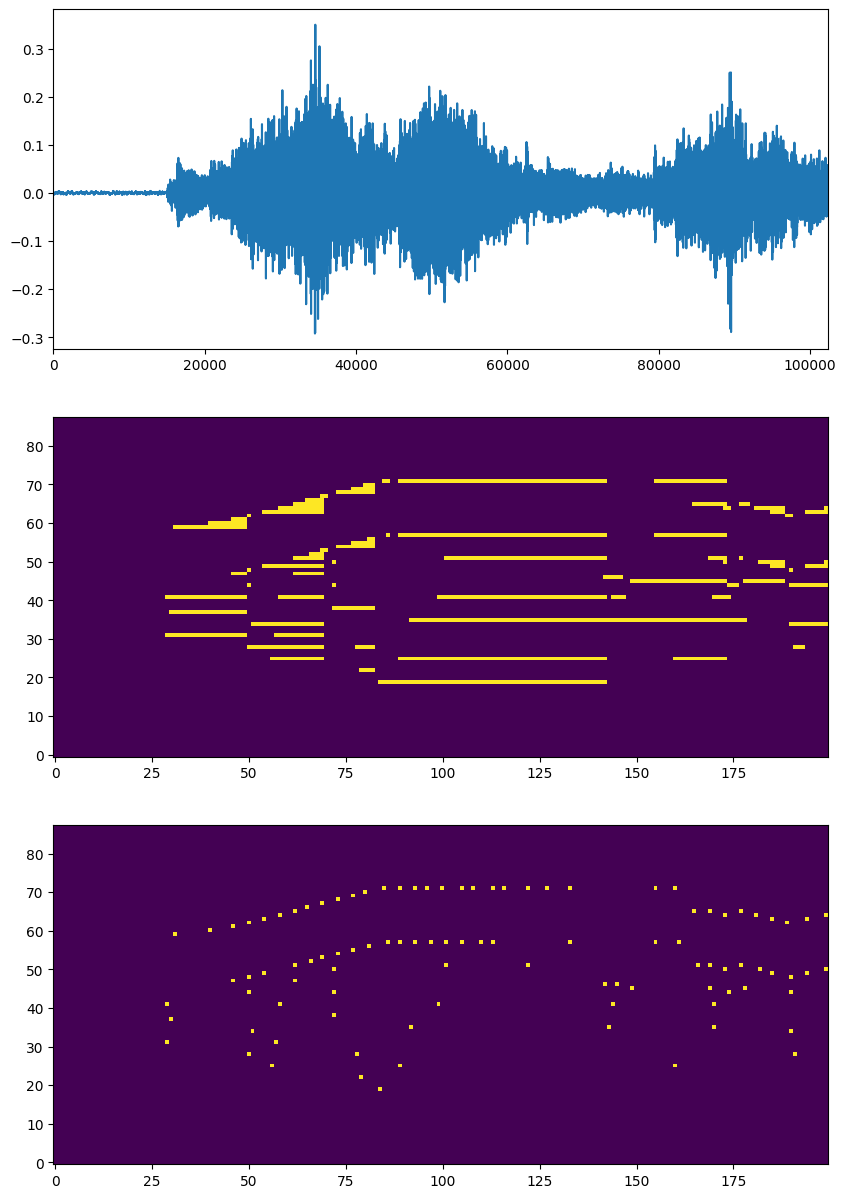

In [5]:
idx = 1 # You can test different idx

data = validation_dataset[idx]
ipd.display(ipd.Audio(data['audio'].numpy()[:400*HOP_SIZE], rate=SAMPLE_RATE))

plt.figure(figsize=(10,15))
plt.subplot(311)
plt.plot(data['audio'].numpy()[:400*HOP_SIZE])
plt.autoscale(enable=True, axis='x', tight=True)
plt.subplot(312)
plt.imshow(data['frame'].numpy()[:400].T, aspect='auto', origin='lower', interpolation='nearest')
plt.subplot(313)
plt.imshow(data['onset'].numpy()[:400].T, aspect='auto', origin='lower', interpolation='nearest')


# 0. Define Baseline model

In [8]:
# Define Training hyperparameters

sequence_length = 102400
lr = 6e-4
batch_size = 16
iterations = 5000
validation_interval = 500
weight_decay = 0
cnn_unit = 48
fc_unit = 256

In [9]:
dataset = MAESTRO_small(path='data',
                        groups=['train'],
                        sequence_length=sequence_length,
                        hop_size=HOP_SIZE,
                        random_sample=True)

# validation_dataset was declared in the cell above
# validation_dataset = MAESTRO_small(path='data',
#                                    groups=['validation'],
#                                    sequence_length=sequence_length,
#                                    hop_size=HOP_SIZE,
#                                    random_sample=False)

Loading 1 group(s) of MAESTRO_small at data


Loading group train:   0%|          | 0/100 [00:00<?, ?it/s]

In [15]:
class LogMelSpectrogram(nn.Module):
    def __init__(self):
        super().__init__()
        self.melspectrogram = transforms.MelSpectrogram(
            sample_rate=SAMPLE_RATE,
            n_fft=N_FFT,
            hop_length=HOP_SIZE,
            f_min=F_MIN,
            f_max=F_MAX,
            n_mels=N_MELS,
            normalized=False)

    def forward(self, audio):
        # Alignment correction to match with piano roll.
        # When they convert the input into frames,
        # pretty_midi.get_piano_roll uses `ceil`,
        # but torchaudio.transforms.melspectrogram uses `round`.
        padded_audio = nn.functional.pad(audio, (HOP_SIZE // 2, 0), 'constant')
        mel = self.melspectrogram(padded_audio)[:, :, 1:]
        mel = mel.transpose(-1, -2)
        mel = torch.log(torch.clamp(mel, min=1e-9))
        return mel


class ConvStack(nn.Module):
    def __init__(self, n_mels, cnn_unit, fc_unit):
        super().__init__()

        # shape of input: (batch_size, 1 channel, frames, input_features)
        self.cnn = nn.Sequential(
            # layer 0
            nn.Conv2d(1, cnn_unit, (3, 3), padding=1),
            nn.BatchNorm2d(cnn_unit),
            nn.ReLU(),
            # layer 1
            nn.Conv2d(cnn_unit, cnn_unit, (3, 3), padding=1),
            nn.BatchNorm2d(cnn_unit),
            nn.ReLU(),
            # layer 2
            nn.MaxPool2d((1, 2)),
            nn.Dropout(0.25),
            nn.Conv2d(cnn_unit, cnn_unit * 2, (3, 3), padding=1),
            nn.BatchNorm2d(cnn_unit * 2),
            nn.ReLU(),
            # layer 3
            nn.MaxPool2d((1, 2)),
            nn.Dropout(0.25),
        )
        self.fc = nn.Sequential(
            nn.Linear((cnn_unit * 2) * (n_mels // 4), fc_unit),
            nn.Dropout(0.5))

    def forward(self, mel):
        x = mel.unsqueeze(1)
        x = self.cnn(x)
        x = x.transpose(1, 2).flatten(-2)
        x = self.fc(x)
        return x


class Transcriber(nn.Module):
    def __init__(self, cnn_unit, fc_unit):
        super().__init__()

        self.melspectrogram = LogMelSpectrogram()

        self.frame_conv_stack = ConvStack(N_MELS, cnn_unit, fc_unit)
        self.frame_fc = nn.Linear(fc_unit, 88)

        self.onset_conv_stack = ConvStack(N_MELS, cnn_unit, fc_unit)
        self.onset_fc = nn.Linear(fc_unit, 88)

    def forward(self, audio):
        mel = self.melspectrogram(audio)

        x = self.frame_conv_stack(mel)  # (B, T, C)
        frame_out = self.frame_fc(x)

        x = self.onset_conv_stack(mel)  # (B, T, C)
        onset_out = self.onset_fc(x)
        return frame_out, onset_out


model = Transcriber(cnn_unit=64, fc_unit=256)

with torch.no_grad():
  out = model(batch['audio'])
print(f'audio_input_shape: {batch["audio"].shape}')
print(f'frame_out_shape: {out[0].shape}')
print(f'onset_out_shape: {out[1].shape}')
print(f'frame_label_shape: {batch["frame"].shape}')
print(f'onset_label_shape: {batch["onset"].shape}')

audio_input_shape: torch.Size([2, 102400])
frame_out_shape: torch.Size([2, 200, 88])
onset_out_shape: torch.Size([2, 200, 88])
frame_label_shape: torch.Size([2, 200, 88])
onset_label_shape: torch.Size([2, 200, 88])


In [11]:
# Train baseline model

train(model_type='baseline',
      logdir='runs/baseline_train',
      dataset=dataset,
      valid_dataset=validation_dataset,
      batch_size=batch_size,
      iterations=iterations,
      validation_interval=validation_interval,
      sequence_length=sequence_length,
      learning_rate=lr,
      weight_decay=weight_decay,
      cnn_unit=cnn_unit,
      fc_unit=fc_unit,
      debug=False,
      save_midi=False
      )

  0%|          | 0/5000 [00:00<?, ?it/s]

/home/minhee/miniconda3/envs/dlma/lib/python3.10/site-packages/mir_eval/transcription.py:167: UserWarning: Estimated notes are empty.
  warnings.warn("Estimated notes are empty.")



metric/loss/frame_loss      : 0.0796
metric/loss/onset_loss      : 0.0061
metric/frame/frame_f1       : 0.6252
metric/frame/onset_f1       : 0.4882
metric/note/f1              : 0.5344
metric/note-with-offsets/f1 : 0.2581

metric/loss/frame_loss      : 0.0653
metric/loss/onset_loss      : 0.0049
metric/frame/frame_f1       : 0.6495
metric/frame/onset_f1       : 0.6483
metric/note/f1              : 0.7453
metric/note-with-offsets/f1 : 0.2712

metric/loss/frame_loss      : 0.0713
metric/loss/onset_loss      : 0.0048
metric/frame/frame_f1       : 0.6676
metric/frame/onset_f1       : 0.6207
metric/note/f1              : 0.7016
metric/note-with-offsets/f1 : 0.3209

metric/loss/frame_loss      : 0.0658
metric/loss/onset_loss      : 0.0045
metric/frame/frame_f1       : 0.6978
metric/frame/onset_f1       : 0.6715
metric/note/f1              : 0.7897
metric/note-with-offsets/f1 : 0.3252

metric/loss/frame_loss      : 0.0621
metric/loss/onset_loss      : 0.0042
metric/frame/frame_f1       : 0.6

Loading group test:   0%|          | 0/10 [00:00<?, ?it/s]


metric/loss/frame_loss : 0.038318704813718796
metric/loss/onset_loss : 0.0025239973329007626
metric/frame/frame_f1 : 0.7377633949064781
metric/frame/onset_f1 : 0.7253659310010625
metric/note/f1 : 0.8321340331789937
metric/note-with-offsets/f1 : 0.5103978894200325
                            loss frame_loss                : 0.038 +- 0.015
                            loss onset_loss                : 0.003 +- 0.002
                           frame frame_precision           : 0.837 +- 0.182
                           frame frame_recall              : 0.680 +- 0.180
                           frame frame_f1                  : 0.738 +- 0.152
                           frame onset_precision           : 0.850 +- 0.098
                           frame onset_recall              : 0.645 +- 0.154
                           frame onset_f1                  : 0.725 +- 0.123
                            note precision                 : 1.000 +- 0.000
                            note recall            

# Problem 1: Implement RNN model
- Implement ``Transcriber_RNN``
  - Using ``nn.LSTM`` and ``nn.Linear``
- You have to declare ``self.frame_lstm``, ``self.frame_fc``, ``self.onset_lstm``, ``self.onset_fc``
  - Both LSTM layers has to be bidirectional, with number of layers of 2, and batch_first is True, hidden_size of ``fc_unit``

In [12]:
class Transcriber_RNN(nn.Module):
    def __init__(self, cnn_unit, fc_unit):
        '''
        TODO: Complete the initialization of the model.

        Args:
          cnn_unit: unit for number of channels in CNN Stack (You don't have to use this in Transcriber_RNN)
          fc_unit: unit ofr number of hidden units in LSTM layer
        '''
        super().__init__()
        # Notice: Changing the initialization order may fail the tests.
        self.melspectrogram = LogMelSpectrogram()

        self.frame_lstm = nn.LSTM(input_size=N_MELS, hidden_size=fc_unit, num_layers=2, batch_first=True, bidirectional=True)
        self.frame_fc = nn.Linear(fc_unit*2, 88)

        self.onset_lstm = nn.LSTM(input_size=N_MELS, hidden_size=fc_unit, num_layers=2, batch_first=True, bidirectional=True)
        self.onset_fc = nn.Linear(fc_unit*2, 88)


    def forward(self, audio):
        # TODO: Question 1
        mel = self.melspectrogram(audio)

        frame_out, _ = self.frame_lstm(mel)
        frame_out = self.frame_fc(frame_out)

        onset_out, _ = self.onset_lstm(mel)
        onset_out = self.onset_fc(onset_out)

        return frame_out, onset_out


model = Transcriber_RNN(cnn_unit=64, fc_unit=256)

out = model(batch['audio'])
print(f'audio_input_shape: {batch["audio"].shape}')
print(f'frame_out_shape: {out[0].shape}')
print(f'onset_out_shape: {out[1].shape}')
print(f'frame_label_shape: {batch["frame"].shape}')
print(f'onset_label_shape: {batch["onset"].shape}')

# Test training with 100 iterations
train(model_type='rnn',
      logdir='runs/rnn_debug',
      dataset=dataset,
      valid_dataset=validation_dataset,
      batch_size=batch_size,
      iterations=100,
      validation_interval=50,
      sequence_length=sequence_length,
      learning_rate=lr,
      weight_decay=weight_decay,
      cnn_unit=cnn_unit,
      fc_unit=fc_unit,
      debug=True,
      save_midi=False
      )

audio_input_shape: torch.Size([2, 102400])
frame_out_shape: torch.Size([2, 200, 88])
onset_out_shape: torch.Size([2, 200, 88])
frame_label_shape: torch.Size([2, 200, 88])
onset_label_shape: torch.Size([2, 200, 88])


  0%|          | 0/100 [00:00<?, ?it/s]


metric/loss/frame_loss      : 0.1614
metric/loss/onset_loss      : 0.0154
metric/frame/frame_f1       : 0.0000
metric/frame/onset_f1       : 0.0000
metric/note/f1              : 0.0000
metric/note-with-offsets/f1 : 0.0000

metric/loss/frame_loss      : 0.1568
metric/loss/onset_loss      : 0.0154
metric/frame/frame_f1       : 0.0000
metric/frame/onset_f1       : 0.0000
metric/note/f1              : 0.0000
metric/note-with-offsets/f1 : 0.0000
Loading 1 group(s) of MAESTRO_small at data


Loading group test:   0%|          | 0/10 [00:00<?, ?it/s]


metric/loss/frame_loss : 0.1379547119140625
metric/loss/onset_loss : 0.013353211805224419
metric/frame/frame_f1 : 0.0
metric/frame/onset_f1 : 0.0
metric/note/f1 : 0.0
metric/note-with-offsets/f1 : 0.0
                            loss frame_loss                : 0.138 +- 0.050
                            loss onset_loss                : 0.013 +- 0.007
                           frame frame_precision           : 0.000 +- 0.000
                           frame frame_recall              : 0.000 +- 0.000
                           frame frame_f1                  : 0.000 +- 0.000
                           frame onset_precision           : 0.000 +- 0.000
                           frame onset_recall              : 0.000 +- 0.000
                           frame onset_f1                  : 0.000 +- 0.000
                            note precision                 : 0.000 +- 0.000
                            note recall                    : 0.000 +- 0.000
                            note f1   

In [13]:
# Train with 5000 iterations
train(model_type='rnn',
      logdir='runs/rnn_debug',
      dataset=dataset,
      valid_dataset=validation_dataset,
      batch_size=batch_size,
      iterations=iterations,
      validation_interval=validation_interval,
      sequence_length=sequence_length,
      learning_rate=lr,
      weight_decay=weight_decay,
      cnn_unit=cnn_unit,
      fc_unit=fc_unit,
      debug=True,
      save_midi=False
      )

  0%|          | 0/5000 [00:00<?, ?it/s]


metric/loss/frame_loss      : 0.1302
metric/loss/onset_loss      : 0.0140
metric/frame/frame_f1       : 0.2186
metric/frame/onset_f1       : 0.0000
metric/note/f1              : 0.0000
metric/note-with-offsets/f1 : 0.0000

metric/loss/frame_loss      : 0.1036
metric/loss/onset_loss      : 0.0121
metric/frame/frame_f1       : 0.3610
metric/frame/onset_f1       : 0.0000
metric/note/f1              : 0.0000
metric/note-with-offsets/f1 : 0.0000

metric/loss/frame_loss      : 0.1044
metric/loss/onset_loss      : 0.0103
metric/frame/frame_f1       : 0.4501
metric/frame/onset_f1       : 0.0467
metric/note/f1              : 0.0477
metric/note-with-offsets/f1 : 0.0193

metric/loss/frame_loss      : 0.0876
metric/loss/onset_loss      : 0.0090
metric/frame/frame_f1       : 0.5113
metric/frame/onset_f1       : 0.1498
metric/note/f1              : 0.1624
metric/note-with-offsets/f1 : 0.0583

metric/loss/frame_loss      : 0.0852
metric/loss/onset_loss      : 0.0084
metric/frame/frame_f1       : 0.5

Loading group test:   0%|          | 0/10 [00:00<?, ?it/s]


metric/loss/frame_loss : 0.048667483031749725
metric/loss/onset_loss : 0.004301184322685003
metric/frame/frame_f1 : 0.66597387783694
metric/frame/onset_f1 : 0.6351772062360297
metric/note/f1 : 0.7552400751703077
metric/note-with-offsets/f1 : 0.25498175553989505
                            loss frame_loss                : 0.049 +- 0.023
                            loss onset_loss                : 0.004 +- 0.003
                           frame frame_precision           : 0.693 +- 0.247
                           frame frame_recall              : 0.702 +- 0.149
                           frame frame_f1                  : 0.666 +- 0.176
                           frame onset_precision           : 0.722 +- 0.071
                           frame onset_recall              : 0.593 +- 0.164
                           frame onset_f1                  : 0.635 +- 0.094
                            note precision                 : 0.977 +- 0.060
                            note recall              

# Problem 2: Implement CRNN model
- Implement ``Transcriber_CRNN``
  - Using ``ConvStack``, ``nn.LSTM`` and ``nn.Linear``
- You have to declare ``self.frame_conv_stack``,  ``self.frame_lstm``, ``self.frame_fc``, ``self.onset_conv_stack``,  ``self.onset_lstm``, ``self.onset_fc``
  - Both LSTM layers has to be bidirectional, with number of layers of 1, and batch_first is True

In [14]:
class Transcriber_CRNN(nn.Module):
    def __init__(self, cnn_unit, fc_unit):
        '''
        TODO: Complete the initialization of the model.

        Args:
          cnn_unit: unit for number of channels in CNN Stack
          fc_unit: unit for number of hidden units in FC layer of CNN stack and LSTM layer
        '''
        super().__init__()
        # Notice: Changing the initialization order may fail the tests.
        self.melspectrogram = LogMelSpectrogram()

        self.frame_conv_stack = ConvStack(N_MELS, cnn_unit, fc_unit)
        self.frame_lstm = nn.LSTM(input_size=fc_unit, hidden_size=fc_unit, num_layers=1, batch_first=True, bidirectional=True)
        self.frame_fc = nn.Linear(fc_unit*2, 88)

        self.onset_conv_stack = ConvStack(N_MELS, cnn_unit, fc_unit)
        self.onset_lstm = nn.LSTM(input_size=fc_unit, hidden_size=fc_unit, num_layers=1, batch_first=True, bidirectional=True)
        self.onset_fc = nn.Linear(fc_unit*2, 88)

    def forward(self, audio):
      '''
      TODO: Complete the forward pass of the model,

      Args:
        audio: torch.Tensor of shape (batch_size, sequence_length)

      Returns:
        frame_out: torch.Tensor of shape (batch_size, sequence_length, 88)
        onset_out: torch.Tensor of shape (batch_size, sequence_length, 88)
      '''
      mel = self.melspectrogram(audio)

      x = self.frame_conv_stack(mel)
      frame_out, _ = self.frame_lstm(x)
      frame_out = self.frame_fc(frame_out)
      
      x = self.onset_conv_stack(mel)
      onset_out, _ = self.onset_lstm(x)
      onset_out = self.onset_fc(onset_out)
      
      return frame_out, onset_out

model = Transcriber_CRNN(cnn_unit=64, fc_unit=256)

out = model(batch['audio'])
print(f'audio_input_shape: {batch["audio"].shape}')
print(f'frame_out_shape: {out[0].shape}')
print(f'onset_out_shape: {out[1].shape}')
print(f'frame_label_shape: {batch["frame"].shape}')
print(f'onset_label_shape: {batch["onset"].shape}')

# Test training with 100 iterations
train(model_type='crnn',
      logdir='runs/crnn_debug',
      dataset=dataset,
      valid_dataset=validation_dataset,
      batch_size=batch_size,
      iterations=100,
      validation_interval=50,
      sequence_length=sequence_length,
      learning_rate=lr,
      weight_decay=weight_decay,
      cnn_unit=cnn_unit,
      fc_unit=fc_unit,
      debug=True,
      save_midi=False
      )

audio_input_shape: torch.Size([2, 102400])
frame_out_shape: torch.Size([2, 200, 88])
onset_out_shape: torch.Size([2, 200, 88])
frame_label_shape: torch.Size([2, 200, 88])
onset_label_shape: torch.Size([2, 200, 88])


  0%|          | 0/100 [00:00<?, ?it/s]


metric/loss/frame_loss      : 0.1600
metric/loss/onset_loss      : 0.0154
metric/frame/frame_f1       : 0.0000
metric/frame/onset_f1       : 0.0000
metric/note/f1              : 0.0000
metric/note-with-offsets/f1 : 0.0000

metric/loss/frame_loss      : 0.1629
metric/loss/onset_loss      : 0.0156
metric/frame/frame_f1       : 0.0000
metric/frame/onset_f1       : 0.0000
metric/note/f1              : 0.0000
metric/note-with-offsets/f1 : 0.0000
Loading 1 group(s) of MAESTRO_small at data


Loading group test:   0%|          | 0/10 [00:00<?, ?it/s]


metric/loss/frame_loss : 0.14206136763095856
metric/loss/onset_loss : 0.013496850617229939
metric/frame/frame_f1 : 0.0
metric/frame/onset_f1 : 0.0
metric/note/f1 : 0.0
metric/note-with-offsets/f1 : 0.0
                            loss frame_loss                : 0.142 +- 0.046
                            loss onset_loss                : 0.013 +- 0.007
                           frame frame_precision           : 0.000 +- 0.000
                           frame frame_recall              : 0.000 +- 0.000
                           frame frame_f1                  : 0.000 +- 0.000
                           frame onset_precision           : 0.000 +- 0.000
                           frame onset_recall              : 0.000 +- 0.000
                           frame onset_f1                  : 0.000 +- 0.000
                            note precision                 : 0.000 +- 0.000
                            note recall                    : 0.000 +- 0.000
                            note f1  

In [15]:
# Train CRNN model
# You can change the hyperparameters to get better results

train(model_type='crnn',
      logdir='runs/crnn_train',
      dataset=dataset,
      valid_dataset=validation_dataset,
      batch_size=batch_size,
      iterations=iterations,
      validation_interval=validation_interval,
      sequence_length=sequence_length,
      learning_rate=lr,
      weight_decay=weight_decay,
      cnn_unit=cnn_unit,
      fc_unit=fc_unit,
      debug=False,
      save_midi=False
      )

  0%|          | 0/5000 [00:00<?, ?it/s]


metric/loss/frame_loss      : 0.1429
metric/loss/onset_loss      : 0.0154
metric/frame/frame_f1       : 0.0000
metric/frame/onset_f1       : 0.0000
metric/note/f1              : 0.0000
metric/note-with-offsets/f1 : 0.0000



metric/loss/frame_loss      : 0.0926
metric/loss/onset_loss      : 0.0123
metric/frame/frame_f1       : 0.3144
metric/frame/onset_f1       : 0.0000
metric/note/f1              : 0.0000
metric/note-with-offsets/f1 : 0.0000

metric/loss/frame_loss      : 0.0756
metric/loss/onset_loss      : 0.0076
metric/frame/frame_f1       : 0.5519
metric/frame/onset_f1       : 0.2244
metric/note/f1              : 0.2380
metric/note-with-offsets/f1 : 0.1053

metric/loss/frame_loss      : 0.0701
metric/loss/onset_loss      : 0.0047
metric/frame/frame_f1       : 0.6283
metric/frame/onset_f1       : 0.6085
metric/note/f1              : 0.6729
metric/note-with-offsets/f1 : 0.3055

metric/loss/frame_loss      : 0.0690
metric/loss/onset_loss      : 0.0042
metric/frame/frame_f1       : 0.6586
metric/frame/onset_f1       : 0.6930
metric/note/f1              : 0.7875
metric/note-with-offsets/f1 : 0.3700

metric/loss/frame_loss      : 0.0609
metric/loss/onset_loss      : 0.0043
metric/frame/frame_f1       : 0.6

Loading group test:   0%|          | 0/10 [00:00<?, ?it/s]


metric/loss/frame_loss : 0.028843265026807785
metric/loss/onset_loss : 0.002584487199783325
metric/frame/frame_f1 : 0.7750005120468983
metric/frame/onset_f1 : 0.7617681727413925
metric/note/f1 : 0.9361924176778247
metric/note-with-offsets/f1 : 0.5361197989906756
                            loss frame_loss                : 0.029 +- 0.020
                            loss onset_loss                : 0.003 +- 0.002
                           frame frame_precision           : 0.860 +- 0.175
                           frame frame_recall              : 0.714 +- 0.195
                           frame frame_f1                  : 0.775 +- 0.180
                           frame onset_precision           : 0.739 +- 0.105
                           frame onset_recall              : 0.790 +- 0.091
                           frame onset_f1                  : 0.762 +- 0.093
                            note precision                 : 0.976 +- 0.031
                            note recall             

# Problem 3: Implement Onsets and Frames model
- Implement ``Transcriber_ONF``
  - Using ``ConvStack``, ``nn.LSTM`` and ``nn.Linear``
- You have to declare ``self.frame_conv_stack``,  ``self.frame_fc``, ``self.onset_lstm``, ``self.onset_fc``, ``self.combined_lstm``, ``self.combined_fc``
  - For LSTM layers, you have to use bidirectional, num_layers 1, and batch_first True
- Model Diagram (CAUTION: You should not output value after Sigmoid, because the loss function already includes Sigmoid layer. However, Onset Prediction to Frame Bi-LSTM should have Sigmoid activation)

<img src="https://github.com/jdasam/ant5015-2023/blob/main/onsets_and_frames.jpg?raw=true" alt="onsets and frames diagram" width=50%>

In [16]:
class Transcriber_ONF(nn.Module):
    def __init__(self, cnn_unit, fc_unit):
        super().__init__()
        '''
        Initialize the model.

        Args:
          cnn_unit: unit for number of channels in CNN Stack
          fc_unit: unit for number of hidden units in FC layer of CNN stack and LSTM layer
        '''
        # Initialize LogMelSpectrogram (assume it exists)
        self.melspectrogram = LogMelSpectrogram()

        # Frame path
        self.frame_conv_stack = ConvStack(N_MELS, cnn_unit, fc_unit)
        self.frame_fc = nn.Linear(fc_unit, 88)

        # Onset path
        self.onset_conv_stack = ConvStack(N_MELS, cnn_unit, fc_unit)
        self.onset_lstm = nn.LSTM(input_size=fc_unit, hidden_size=fc_unit, num_layers=1, batch_first=True, bidirectional=True)
        self.onset_fc = nn.Linear(fc_unit * 2, 88)

        # Combined path
        self.combined_lstm = nn.LSTM(input_size=fc_unit + 88, hidden_size=fc_unit, num_layers=1, batch_first=True, bidirectional=True)
        self.combined_fc = nn.Linear(fc_unit * 2, 88)

    def forward(self, audio):
        mel = self.melspectrogram(audio)

        # Frame prediction path
        frame_features = self.frame_conv_stack(mel)  # Shape: (batch_size, time, fc_unit)
        frame_out = self.frame_fc(frame_features)    # Shape: (batch_size, time, 88)

        # Onset prediction path
        onset_features = self.onset_conv_stack(mel)  # Shape: (batch_size, time, fc_unit)
        onset_features, _ = self.onset_lstm(onset_features)
        onset_out = self.onset_fc(onset_features)    # Shape: (batch_size, time, 88)

        # Apply Sigmoid activation to onset prediction before combining
        onset_out_sigmoid = torch.sigmoid(onset_out)

        # Combine frame and onset predictions
        combined_features = torch.cat((frame_features, onset_out_sigmoid), dim=-1)  # Shape: (batch_size, time, fc_unit + 88)
        combined_lstm_out, _ = self.combined_lstm(combined_features)
        frame_out = self.combined_fc(combined_lstm_out)  # Shape: (batch_size, time, 88)

        return frame_out, onset_out

# Sample usage with dummy data
batch = {'audio': torch.randn(2, 16000), 'frame': torch.randn(2, 16000, 88), 'onset': torch.randn(2, 16000, 88)}

model = Transcriber_ONF(cnn_unit=64, fc_unit=256)
with torch.no_grad():
  out = model(batch['audio'])
print(f'audio_input_shape: {batch["audio"].shape}')
print(f'frame_out_shape: {out[0].shape}')
print(f'onset_out_shape: {out[1].shape}')
print(f'frame_label_shape: {batch["frame"].shape}')
print(f'onset_label_shape: {batch["onset"].shape}')

# Test training with 100 iterations
def train(model_type, logdir, dataset, valid_dataset, batch_size, iterations, validation_interval, sequence_length, learning_rate, weight_decay, cnn_unit, fc_unit, debug, save_midi):
    # Training logic here
    pass

# Call train function with appropriate parameters
train(model_type='ONF',
      logdir='runs/onf_debug',
      dataset=None,  # placeholder, replace with actual dataset
      valid_dataset=None,  # placeholder, replace with actual validation dataset
      batch_size=16,
      iterations=100,
      validation_interval=50,
      sequence_length=16000,
      learning_rate=1e-3,
      weight_decay=1e-4,
      cnn_unit=64,
      fc_unit=256,
      debug=True,
      save_midi=False
      )


audio_input_shape: torch.Size([2, 16000])
frame_out_shape: torch.Size([2, 31, 88])
onset_out_shape: torch.Size([2, 31, 88])
frame_label_shape: torch.Size([2, 16000, 88])
onset_label_shape: torch.Size([2, 16000, 88])


In [17]:
train(model_type='ONF',
      logdir='runs/onf_train',
      dataset=dataset,
      valid_dataset=validation_dataset,
      batch_size=batch_size,
      iterations=iterations,
      validation_interval=validation_interval,
      sequence_length=sequence_length,
      learning_rate=lr,
      weight_decay=weight_decay,
      cnn_unit=cnn_unit,
      fc_unit=fc_unit,
      debug=False,
      save_midi=False
      )

# Inference
- Transcribe an audio file of your choice
  - The recording has to be solo piano performance
- Describe the result of your transcription
  - When does the model make mistakes?
  - What are the limitations of the model?

In [16]:
def load_audio(audiofile):
    audio, sr = torchaudio.load(audiofile)
    audio = torchaudio.transforms.Resample(sr, SAMPLE_RATE)(audio)
    return audio.mean(dim=0)


def transcribe(audio, model, save_name, max_len, device='cuda'):
    print(f'save_path: {save_name}')
    audio = audio[:max_len * SAMPLE_RATE]
    t_audio = audio.to(torch.float).to(device)
    pad_len = math.ceil(len(t_audio) / HOP_SIZE) * HOP_SIZE - len(t_audio)
    t_audio = torch.unsqueeze(F.pad(t_audio, (0, pad_len)), 0)

    frame_logit, onset_logit = model(t_audio)
    onset = torch.sigmoid(onset_logit[0])
    frame = torch.sigmoid(frame_logit[0])

    p_est, i_est = extract_notes(onset, frame)

    scaling = HOP_SIZE / SAMPLE_RATE

    i_est = (i_est * scaling).reshape(-1, 2)
    p_est = np.array([midi_to_hz(MIN_MIDI + pitch) for pitch in p_est])

    np_filename = Path(save_name).parent / (Path(save_name).stem + '.npz')
    np.savez(np_filename, onset=onset.cpu().numpy(), frame=frame.cpu().numpy())

    midi_filename = Path(save_name).parent / (Path(save_name).stem + '.midi')
    save_midi(midi_filename, p_est, i_est, [64] * len(p_est))

    wav_filename = Path(save_name).parent / (Path(save_name).stem + '.wav')
    midi_file = pretty_midi.PrettyMIDI(str(midi_filename))
    synth_audio = midi_file.fluidsynth(fs=16000)
    soundfile.write(wav_filename, synth_audio, 16000)



In [17]:
# simple test file: monophonic piano scale
import locale
locale.getpreferredencoding = lambda: "UTF-8"

# !wget https://www.audiolabs-erlangen.de/resources/MIR/FMP/data/C3/FMP_C3_F03.mp3

In [ ]:
model_state_path = ... # path to the model state file. it is named like 'runs/baseline_train/model-5000.pt'
audio_file_path = ...# path to the audio file.
max_len = 30  # seconds

model_state_path = 'runs/baseline_train/model-5000.pt'
audio_file_path = 'FMP_C3_F03.mp3'
DEV = 'cuda'


with torch.inference_mode():
    ckp = torch.load(model_state_path, map_location='cpu')
    model = Transcriber(ckp['cnn_unit'], ckp['fc_unit'])

    model.load_state_dict(ckp['model_state_dict'])
    model.eval()
    model = model.to(DEV)

    audio = load_audio(audio_file_path)

    save_path = Path(model_state_path).parent / (
            Path(audio_file_path).stem + '_transcribed')

    transcribe(audio, model, save_path, max_len, device=DEV)